# Prerequisites

In [1]:
import sys

sys.path.append("..")

In [2]:
%load_ext autoreload
%autoreload 2

import os

import cc3d
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.v2 as transforms
from IPython.display import clear_output
from skimage.io import imread, imsave
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

import transforms3d as T
from dataset3d import BNSet, BNSetMasks, get_dloader_mask
from model3d import CNN3d
from util3d import show_volume, get_saliency3d, get_obj_score3d

In [3]:
data_dir = "../data/bugNIST_DATA"

name_legend = {
    "ac": "brown_cricket",
    "bc": "black_cricket",
    "bf": "blow_fly",
    "bl": "buffalo_bettle_larva",
    "bp": "blow_fly_pupa",
    "cf": "curly-wing_fly",
    "gh": "grasshopper",
    "ma": "maggot",
    "ml": "mealworm",
    "pp": "green_bottle_fly_pupa",
    "sl": "soldier_fly_larva",
    "wo": "woodlice",
}

device = "cuda" if torch.cuda.is_available() else "cpu"

# Dataloaders

In [4]:
lr = 1e-4

batch_size = 16
num_workers = 8

subset = ["ac", "bc"]

trainloader = get_dloader_mask(
"train", batch_size, data_dir=data_dir, subset=subset, num_workers=num_workers, pin_memory=True, persisten_workers=True
)

model = CNN3d(len(subset))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

In [5]:
model.train()

stats = {}
for epoch in range(50):
    metrics_train = {
        "loss": [],
        "preds": [],
        "labels": [],
    }

    print(f"Epoch {epoch}")
    for volumes, labels, masks in tqdm(trainloader):
        out = model((volumes * masks).to(device))

        loss = criterion(out, labels.type(torch.LongTensor).to(device))
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        _, indices = torch.max(out.cpu(), 1)

        metrics_train["loss"].append(loss.cpu().detach().item())
        metrics_train["preds"].append(indices.detach().numpy())
        metrics_train["labels"].append(labels.numpy())

    performance = {
        "loss": np.mean(metrics_train["loss"]),
        "accuracy": np.mean(
            np.concatenate(metrics_train["preds"])
            == np.concatenate(metrics_train["labels"])
        ).item(),
    }
    print(performance)
    stats[epoch] = performance

Epoch 0


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.6601802504831745, 'accuracy': 0.6148148148148148}
Epoch 1


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.6340947753639632, 'accuracy': 0.6511784511784512}
Epoch 2


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.6186711112017272, 'accuracy': 0.6632996632996633}
Epoch 3


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5987140510671882, 'accuracy': 0.6888888888888889}
Epoch 4


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5873676349398911, 'accuracy': 0.6821548821548822}
Epoch 5


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5767508395897445, 'accuracy': 0.7117845117845117}
Epoch 6


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5927885059387453, 'accuracy': 0.6996632996632997}
Epoch 7


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5574003865001023, 'accuracy': 0.7232323232323232}
Epoch 8


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5671159214870904, 'accuracy': 0.7245791245791245}
Epoch 9


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.543027457691008, 'accuracy': 0.7387205387205387}
Epoch 10


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5629005140514785, 'accuracy': 0.7286195286195286}
Epoch 11


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5392287748475229, 'accuracy': 0.7474747474747475}
Epoch 12


  0%|          | 0/93 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
dloader = get_dloader_mask(
    "train", 1, data_dir=data_dir, subset=subset, num_workers=0
)
model.eval();

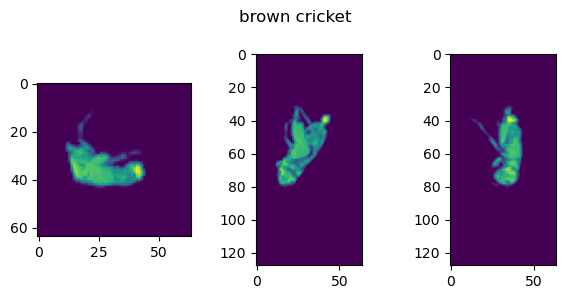

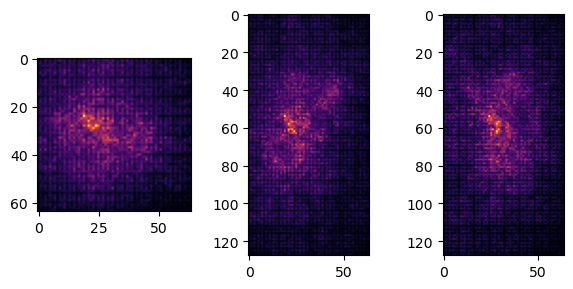

(0.664083895013236, 0, 0)

In [45]:
volumes, labels, masks = next(iter(dloader))
volumes = volumes * masks

slc, score, indices, out = get_saliency3d(model, volumes * masks, device=device)
obj_score = get_obj_score3d(slc, masks)

slc_abs = np.abs(slc)

show_volume(volumes.detach().numpy(), labels.item())
show_volume(slc_abs / slc_abs.max(), cmap="inferno")
obj_score, indices.item(), labels.item()